## Introduction to Neural Networks

(in TensorFlow)



In [110]:
import numpy as np
from matplotlib import pyplot as plt

# choose a different matplotlib style (all styles can be found at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#print(plt.style.available)  # uncomment to see available styles
plt.style.use('dark_background')

### Some Toy Dataset

We will focus on tabular data first, i.e. data that is arranged in rows and tables (no time series yet). As such, we can map a set of inputs $x=[x_1, ..., x_n]$ to outputs $y=[y_1, ..., y_m]$. We will have $N$ data samples. 

**Modeling Task**: translate a sinusoidal input signal $u=\sin(\omega t)$ to its 45°-phase-shifted copy $q=\sin(\omega t-\pi/4)$. 

*Note:* 
- this problem does not involve any memory
- this problem is nonlinear, i.e. it involves learning more than $y = x-C$, where $C$ is some constant.

The model should be able to solve the task for variable frequencies $\omega_j$. We draw the frequencies randomly from a range of values.  

Model setup: the model receives a single input signal $u_i = \sin(\omega_j t_i)$ and the corresponding frequency $\omega_j$. The output is the corresponding phase-lagged signal $q_i=\sin(\omega_j t_i-\pi/4)$. 

`x = [u, omega]`, shape: `[2,1]`

`y = [q]`, shape: `[1,1]` 




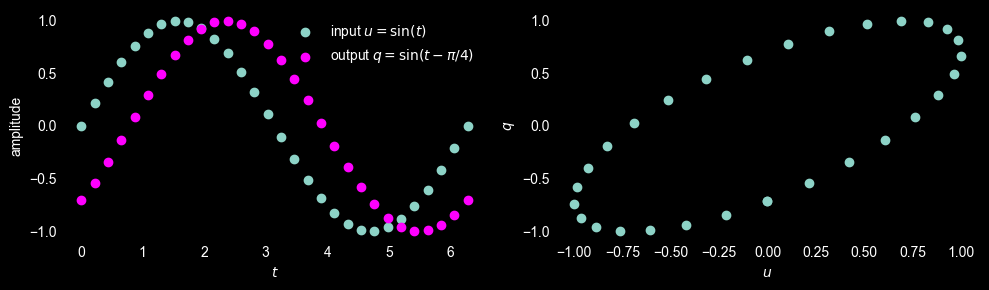

In [111]:
t = np.linspace(0, 2 * np.pi, 30)
u = np.sin(t)
q = np.sin(t - np.pi / 4)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(t, u, label=r'input $u = \sin(t)$')
plt.scatter(t, q, label=r'output $q = \sin(t - \pi/4)$', color='magenta')
plt.xlabel(r'$t$')
plt.ylabel('amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(u, q)
plt.xlabel(r'$u$')
plt.ylabel(r'$q$')
plt.tight_layout()
plt.show()


In [112]:

def create_phase_shift_dataset(n_samples, freq_range=(1.0, 10.0)):
    """
    Generates a dataset for the phase-shifted sine problem.
    As no time dependence is given, we sample frequencies and times uniformly.
    There is no strict need to compute full sine wave, just the values at sampled points.
    
    Args:
        n_samples (int): Number of samples to generate.
        freq_range (tuple): (min_freq, max_freq) for omega sampling.
        
    Returns:
        X (np.ndarray): shape (n_samples, 2), columns [u, omega]
        y (np.ndarray): shape (n_samples, 1), column [q]
    """
    
    # time range for the sine wave
    t_min=0 
    t_max=2*np.pi
    
    omegas = np.random.uniform(freq_range[0], freq_range[1], size=n_samples)
    ts = np.random.uniform(t_min, t_max, size=n_samples)
    u = np.sin(omegas * ts)
    q = np.sin(omegas * ts - np.pi/4)
    x = np.stack([u, omegas], axis=1)
    y = q.reshape(-1, 1)
    return x, y

### Create a training and test set

We will train the model on the training set, and evaluate predictions on the test set to assess the generalization properties. We split according to a 80-20 ratio. 

It is highly recommended to use sklearn's splitting functionalities, particularly the stratified splitting when working with classification problems.

shape of x: (1000, 2)
shape of y: (1000, 1)
number of training samples: 800
number of test samples: 200


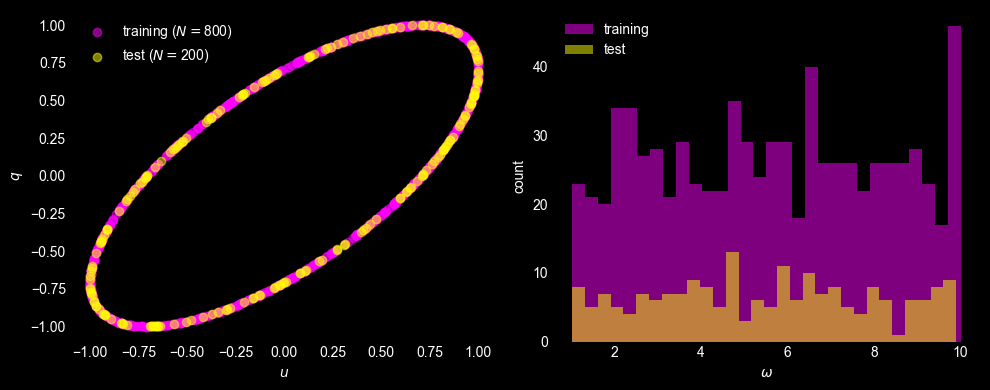

In [113]:
from sklearn.model_selection import train_test_split

# Create the dataset
x, y = create_phase_shift_dataset(n_samples=1000)

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'shape of x: {x.shape}')
print(f'shape of y: {y.shape}')
print(f'number of training samples: {len(x_train)}')
print(f'number of test samples: {len(x_test)}')

# Visualize the dataset
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], y_train, alpha=0.5, label=fr'training ($N=${len(x_train)})',color='magenta')
plt.scatter(x_test[:, 0], y_test, alpha=0.5, label=rf'test ($N=${len(x_test)})', color='yellow')    
plt.xlabel(r'$u$')
plt.ylabel(r'$q$')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(x_train[:, 1], bins=30, alpha=0.5, label='training',color='magenta')
plt.hist(x_test[:, 1], bins=30, alpha=0.5, label='test', color='yellow')
plt.xlabel(r'$\omega$')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.show()

### Fitting a neural network estimator

We are fitting a vanilla-type artificial neural network, i.e. a feedforward neural net, to the given data using the Keras API. The network has the following structure: 
1. Input layer
2. First hidden layer with 64 neurons and ReLU activation function
3. Second hidden layer with 32 neurons and ReLU activation function
4. Output layer having as many neurons as we have output quantities (1 here)

**Important**:
- input shape to the network is `[2,]`, i.e. 2 features. 
- output shape of the network is `[1,]`, i.e. 1 target.
- regression problem: use the `linear` activation function in the output layer


In [ ]:
from tensorflow.keras.models import Sequential  # the model class
from tensorflow.keras.layers import Dense, Input  # the layers we will use

input_shape = x_train.shape[1]  # number of input features ()
output_shape = y_train.shape[1]  # number of output features (1)

# Create a simple feedforward neural network model (using the Sequential API)
model = Sequential()
model.add(Input(shape=(input_shape,)))  # input layer <-- always needed!
model.add(Dense(128, activation='relu'))  # hidden layer with 64 neurons and ReLU activation
model.add(Dense(128, activation='relu'))  # another hidden layer with 32 neurons and ReLU activation
model.add(Dense(output_shape, activation='linear'))  # output layer with linear activation (default)

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# Print the model summary to see the architecture
model.summary()

# Train the model on the training data. The returned `history` object contains training metrics.
history = model.fit(x_train, y_train, # training data
                    validation_data=(x_test, y_test), # validation data to monitor performance on unseen data
                    epochs=200, # how many times to iterate over the training data
                    batch_size=128,  # how many samples to process before updating the model weights 
                    verbose=2,  # verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
                    )

# store the model to disk
model.save('phase_shift_model.h5')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 - 1s - 78ms/step - loss: 0.4998 - val_loss: 0.3733
Epoch 2/200
7/7 - 0s - 9ms/step - loss: 0.3364 - val_loss: 0.3096
Epoch 3/200
7/7 - 0s - 9ms/step - loss: 0.2888 - val_loss: 0.2666
Epoch 4/200
7/7 - 0s - 8ms/step - loss: 0.2646 - val_loss: 0.2731
Epoch 5/200
7/7 - 0s - 9ms/step - loss: 0.2633 - val_loss: 0.2680
Epoch 6/200
7/7 - 0s - 9ms/step - loss: 0.2667 - val_loss: 0.2646
Epoch 7/200
7/7 - 0s - 8ms/step - loss: 0.2643 - val_loss: 0.2801
Epoch 8/200
7/7 - 0s - 8ms/step - loss: 0.2681 - val_loss: 0.2615
Epoch 9/200
7/7 - 0s - 8ms/step - loss: 0.2569 - val_loss: 0.2612
Epoch 10/200
7/7 - 0s - 9ms/step - loss: 0.2533 - val_loss: 0.2560
Epoch 11/200
7/7 - 0s - 9ms/step - loss: 0.2517 - val_loss: 0.2589
Epoch 12/200
7/7 - 0s - 8ms/step - loss: 0.2530 - val_loss: 0.2550
Epoch 13/200
7/7 - 0s - 8ms/step - loss: 0.2536 - val_loss: 0.2549
Epoch 14/200
7/7 - 0s - 8ms/step - loss: 0.2528 - val_loss: 0.2577
Epoch 15/200
7/7 - 0s - 8ms/step - loss: 0.2521 - val_loss: 0.2566
Epo

#### Visualize the NN training run

We have trained the NN to reduce the MSE error on the training set. During each optimization iteration, we have also used the current model weights to make predictions on the hold-out test set. Hence, we can study how well the model generalizes to new unseen data points, and identify the point at which overfitting sets in (loss for training set decreases, loss for test set increases).

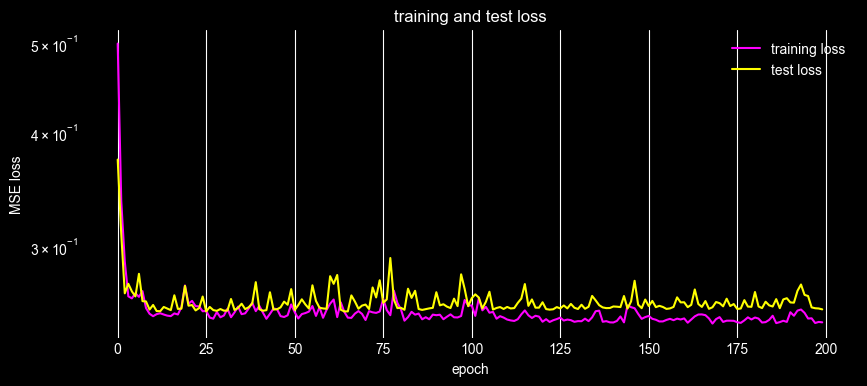

In [115]:

# Plot the training and test loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='training loss', color='magenta')
plt.plot(history.history['val_loss'], label='test loss', color='yellow')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.yscale('log')  # use logarithmic scale for better visibility of loss values
plt.title('training and test loss')
plt.grid()
plt.show()

### Evaluate the model

Let's see how well the model can make predictions on data that was not used for training, i.e. on the test set samples. 

To make predictions, call `model.predict(x)`, where is are new inputs.

We will use a plot that shows the predicted against the expected (i.e. ground truth targets) values. A perfect model would result in the identity line. 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


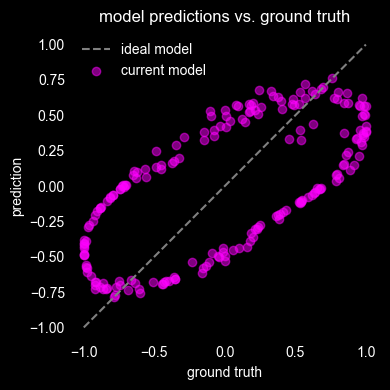

In [ ]:
# load the model from disk (if needed)
from tensorflow.keras.models import load_model
model = load_model('phase_shift_model.h5')

# plot the predictions vs. ground truth
y_pred = model.predict(x_test)

plt.figure(figsize=(4, 4))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--', label='ideal model')
plt.xlabel(r'ground truth')
plt.ylabel(r'prediction')
plt.scatter(y_test, y_pred, alpha=0.5, color='magenta', label='current model')
plt.title('model predictions vs. ground truth')
plt.legend()
plt.tight_layout()
plt.show()

### Deploy model for predictions

We will use the model to compute the phase-shift of a complete sinusoidal time sequence.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


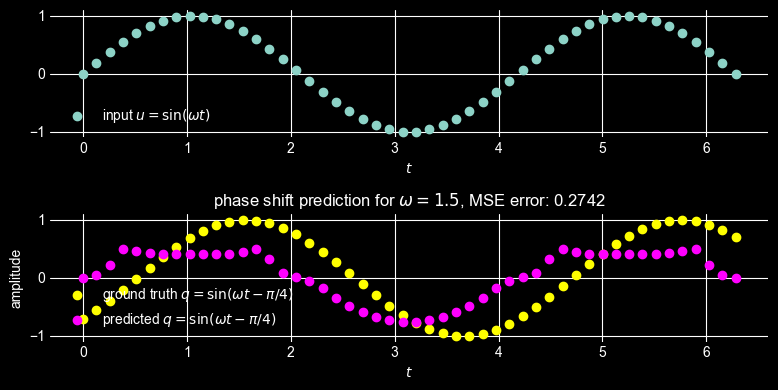

In [117]:
t_new = np.linspace(0, 2 * np.pi, 50)
omega = 1.5
u_new = np.sin(omega * t_new)
q_new = np.sin(omega * t_new - np.pi / 4)

inputs = np.column_stack((u_new, np.ones_like(u_new)*omega))

# Use the model to predict q for the new u values
q_pred = model.predict(inputs)

# Compute the mean squared error of the predictions
mse_err = np.mean((q_new - q_pred.flatten()) ** 2)


# plot the new data and the model predictions
plt.figure(figsize=(8, 4))
plt.subplot(2,1, 1)
plt.scatter(t_new, u_new, label=r'input $u = \sin(\omega t)$')
plt.xlabel(r'$t$')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.scatter(t_new, q_new, label=r'ground truth $q = \sin(\omega t - \pi/4)$', color='yellow')
plt.scatter(t_new, q_pred, label=r'predicted $q = \sin(\omega t - \pi/4)$', color='magenta')
plt.xlabel(r'$t$')
plt.ylabel('amplitude') 
plt.legend()
plt.grid()
plt.title(fr'phase shift prediction for $\omega = {omega}$, MSE error: {mse_err:.4f}')
plt.tight_layout()
plt.show()

### Limits of generalization: predictions for out-of distribution samples

We have trained the model on a specific range of $\omega$ values. Let's observe how the model prediction error evolves along $\omega$, and how the model performs in the trainig range, and how it performs outside the training range. 

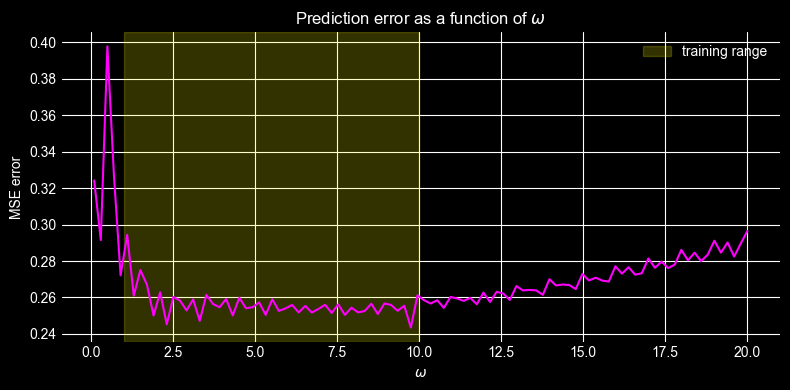

In [118]:
# small helper function to create ground truth data and predictions for a given omega
def compute_prediction_error(model, omega_grid):
    errors = []
    for omega in omega_grid:
        t_new = np.linspace(0, 2 * np.pi, 50)
        u_new = np.sin(omega * t_new)
        q_new = np.sin(omega * t_new - np.pi / 4)

        inputs = np.column_stack((u_new, np.ones_like(u_new) * omega))
        q_pred = model.predict(inputs, verbose=0)
        mse_err = np.mean((q_new - q_pred.flatten()) ** 2)
        errors.append(mse_err)
    return np.array(errors)

# Create a grid of omega values to evaluate the model. 
# Training data was sampled uniformly in the range [1.0, 10.0], so we will use this range for evaluation.
omega_grid = np.linspace(0.1, 20.0, 100)

# Compute the prediction errors for the grid of omega values
errors = compute_prediction_error(model, omega_grid)

# Plot the prediction errors as a function of omega
plt.figure(figsize=(8, 4))  
# shaddow the area used for training
plt.axvspan(1.0, 10.0, color='yellow', alpha=0.2, label='training range')
plt.plot(omega_grid, errors, color='magenta')
plt.xlabel(r'$\omega$')
plt.ylabel('MSE error')
plt.title(r'Prediction error as a function of $\omega$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()